###  Created by Luis Alejandro (alejand@umich.edu)

Training logistic regression models with regularization using different gradient based methods (manually implemented) on a simulated dataset. Uses polynomial expansion to fit non-linear boundaries. Also computes training metrics.

In [1]:
import scipy.io as sio
import scipy.optimize as opt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
import numpy as np
import numpy.random as rnd
import numpy.linalg as alg
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import display, clear_output
import keyboard
from enum import Enum

In [2]:
# Functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def plot_boundary(ax,w,X,y,mesh,threshold):
    # boundary and regions
    color_map = ListedColormap(('red', 'blue'))
    positive = (y == 1)
    h = sigmoid(np.matmul(mesh,w))
    ax.scatter(X[positive,1],X[positive,2], c = 'blue')
    ax.scatter(X[~positive,1],X[~positive,2], c = 'red')
    pts = int(np.sqrt(mesh.shape[0]))
    x1 = mesh[:,1].reshape((pts,pts))
    x2 = mesh[:,2].reshape((pts,pts))
    z = h.reshape((pts,pts))
    ax.contour(x1, x2, z, levels = [threshold], colors = 'black')
    ax.contourf(x1, x2, z >= threshold, alpha = 0.10, cmap = color_map)
    
def plot_cost(ax,J,niter):
    ax.plot(np.arange(1,niter+1), J[:niter], 'k.-')
    ax.grid() 
    
def compute_metrics(w,X,y):
    h = sigmoid(np.matmul(X,w))
    y_pred = (h >= threshold)
    print('Accuracy: ', '%.2f'  % accuracy_score(y, y_pred))
    print('F1 Score: ', '%.2f'  % f1_score(y, y_pred))
    print('Recall: ', '%.2f'  % recall_score(y, y_pred))
    print('Precision: ', '%.2f'  % precision_score(y, y_pred))
    
class GradType(Enum):
    BATCH_GRAD = 0
    ADAGRAD = 1
    LINE_SEARCH = 2
    NEWTON_METHOD = 3

In [3]:
# Read data and build 2D mesh
dataset = sio.loadmat('../../datasets/classification/demolog1.mat')
X = dataset['X']
y = dataset['y'].flatten()
bottom = np.min(X,axis=0)
top = np.max(X,axis=0)
pts = 500
mx = np.linspace(bottom[0], top[0], pts)  # x1
my = np.linspace(bottom[1], top[1], pts)  # x2
mx, my = np.meshgrid(mx, my)
mesh = np.vstack((mx.flatten(), my.flatten())).T
degree = 10
ps = PolynomialFeatures(degree = degree)
ps.fit(X)
X = ps.transform(X)
mesh = ps.transform(mesh)
sc = StandardScaler()
sc.fit(X[:,1:])
X[:,1:] = sc.transform(X[:,1:])
mesh[:,1:] = sc.transform(mesh[:,1:])
m,d = X.shape

In [4]:
# Params
MAX_ITER = 1000
MIN_DELTA = 1e-5
batch_size = None
grad_method = GradType.ADAGRAD
threshold = 0.5
epsilon = 1e-10
reg = 1

In [5]:
# Init algorithm
niter = 0
delta_J = MIN_DELTA
W = 1e-4 * rnd.randn(d,MAX_ITER)
# Computes initial cost
h = sigmoid(X.dot(W[:,niter]))
loglikelihood = sum([np.log(prob) if label else np.log(1-prob) for prob,label in zip(h,y)]) 
loglikelihood -= reg*(W[1:,niter]**2).sum()
J = np.array([-loglikelihood]*MAX_ITER)
cum_grad = np.zeros((d,))

Accuracy:  0.82
F1 Score:  0.83
Recall:  0.88
Precision:  0.78


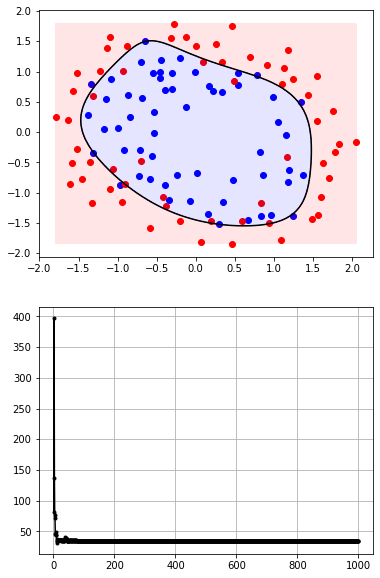

In [6]:
# Solve for w and plots progress
plot_progress = True
fig = plt.figure()
fig.set_size_inches(6,10)
ax_boundary = fig.add_subplot(2,1,1) 
ax_cost = fig.add_subplot(2,1,2) 

while niter < MAX_ITER - 1 and abs(delta_J) >= MIN_DELTA:
    # plot graphical progress
    if plot_progress == True:
        ax_boundary.cla()
        ax_cost.cla()
        plot_boundary(ax_boundary,W[:,niter],X,y,mesh,threshold)
        plot_cost(ax_cost,J,niter)
        display(fig)
        clear_output(wait = True)
        plt.pause(0.1)
        if keyboard.is_pressed('Esc'):
            plot_progress = False

    # Determines gradient
    # batch
    if batch_size == None: 
        h = sigmoid(X.dot(W[:,niter]))
        extra = np.concatenate(([0],2*reg*W[1:,niter]))
        grad = (X.T).dot(h - y) + extra
    # stochastic
    else: 
        indexes = rnd.permutation(m)[:batch_size]
        h = sigmoid(X[indexes,:].dot(W[:,niter]))
        extra = np.concatenate(([0],2*reg*W[1:,niter]))
        grad = (X[indexes,:].T).dot(h - y[indexes]) + extra
        
    # Determines update rule (step) according to chosen method
    if grad_method == GradType.BATCH_GRAD:
        alpha = 1e-2
        step = alpha * grad
    elif grad_method == GradType.ADAGRAD:
        alpha = 1
        cum_grad += (grad**2)
        step = (alpha / np.sqrt((epsilon + cum_grad))) * grad
    elif grad_method == GradType.LINE_SEARCH:
        S = np.diag(h*(1-h))
        H = (X.T).dot(S).dot(X) + np.diag(extra)
        alpha = (grad.T).dot(grad) / (grad.T).dot(H).dot(grad)
        step = alpha * grad
    elif grad_method == GradType.NEWTON_METHOD:
        S = np.diag(h*(1-h))
        H = (X.T).dot(S).dot(X) + np.diag(extra) 
        step = alg.solve(H,grad)  #step = alg.pinv(H).dot(grad)

    # Move iteration pointer
    niter = niter + 1    
    W[:,niter] = W[:,niter - 1] - step
    h = sigmoid(X.dot(W[:,niter]))
    loglikelihood = sum([np.log(prob) if label else np.log(1-prob) for prob,label in zip(h,y)]) 
    loglikelihood += reg*(W[1:,niter]**2).sum()
    J[niter] = -loglikelihood
    delta_J = J[niter - 1] - J[niter]

compute_metrics(W[:,niter],X,y)
ax_boundary.cla()
ax_cost.cla()
plot_boundary(ax_boundary,W[:,niter],X,y,mesh,threshold)
plot_cost(ax_cost,J,niter)
display(fig)